## 1. Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from imblearn.over_sampling import SMOTE
import function_library as lib
from function_library import display_importances

from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_auc_score, log_loss, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

## 2. Import Data

In [2]:
df = pd.read_csv(r'data_modeling.csv')

In [3]:
df.shape

(124494, 21)

In [4]:
df['event'] = df['event'].replace({
    0 : 1,
    1 : 0
})

In [5]:
df['event'].value_counts()

1    124388
0       106
Name: event, dtype: int64

In [6]:
df.head(2)

,date,machine,event,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,hari,bulan,dayofyear,weekofyear,dayofweek,quarter,is_month_start,is_month_end,is_weekend
0,2015-01-01,S1F01085,1,0,7,407438,215630672,6,0,52,56,0,1,1,1,1,3,1,1,0,0
1,2015-02-01,S1F01085,1,0,7,407438,1650864,6,0,52,56,0,1,2,32,5,6,1,1,0,1


## 3.0 Modeling

### 3.1 Baseline Modeling

In [7]:
x = df.drop(columns=['date', 'machine', 'event'])
y = df[['event']]

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=42)

In [9]:
lib.baseline_model(LogisticRegression(), x_train, y_train, x_test, y_test)

test set roc_auc_score is 0.53719


In [10]:
lib.baseline_model(KNeighborsClassifier(), x_train, y_train, x_test, y_test)

test set roc_auc_score is 0.51635


In [11]:
lib.baseline_model(LGBMClassifier(max_depth=4), x_train, y_train, x_test, y_test)

test set roc_auc_score is 0.74456


- Summary Modelling:
    - AUC Logreg : 0.53
    - AUC KNN : 0.51
    - AUC LGBM : 0.74
- Paling bagus menggunakan LGBM maka di step selanjutnya saya coba menggunakan 10 Fold CV untuk LGBM

### 3.2 Modelling LGBM with cross validation (Best Model)

- dengan menggunakan teknik KFold CV

Starting LightGBM. Data shape: (124494, 19)
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.681734
Early stopping, best iteration is:
[4]	valid_0's auc: 0.916735
Fold  1 AUC : 0.916735
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.5708
Early stopping, best iteration is:
[1]	valid_0's auc: 0.843045
Fold  2 AUC : 0.843045
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.541786
Early stopping, best iteration is:
[5]	valid_0's auc: 0.948593
Fold  3 AUC : 0.948593
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.758882
Early stopping, best iteration is:
[1]	valid_0's auc: 0.891302
Fold  4 AUC : 0.891302
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.86839
[400]	valid_0's auc: 0.881936
[600]	valid_0's auc: 0.878206
Early stopping, best iteration is:
[476]	valid_0's auc: 0.883495
Fold  5 AUC : 0.863502
Trainin

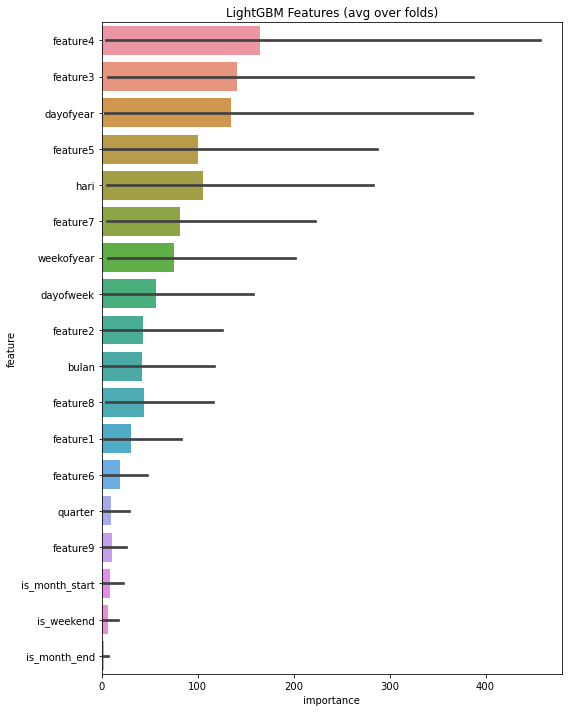

In [12]:
feature_importance_df, hasil_prediksi = lib.kfold_lightgbm(df=df, num_folds=10, stratified=True, categorical=[])

- dengan menggunakan teknik 10 Fold CV didapatkan hasil AUC yang lebih baik yg semula dari 0.74 (baseline) menjadi 0.76 (Full AUC Score) dengan rata-rata AUC 0.83 +- 0.08
- hasil feature importance menunjukan bahwa ternyata feature4, dan feature3 dan dayofyear merupakan feature yang paling penting dalam menentukan terjadinya event.
***

In [13]:
hasil_prediksi_2 = np.where(hasil_prediksi <= 0.2, 0, 1)
hasil_prediksi_2 = pd.DataFrame(hasil_prediksi_2, columns=['prediksi'])
hasil_prediksi_2['aktual'] = y

#predicted, actual
tn, fp, fn, tp = confusion_matrix(hasil_prediksi_2['aktual'], hasil_prediksi_2['prediksi']).ravel()
confusion_matrix(hasil_prediksi_2['aktual'], hasil_prediksi_2['prediksi'])

array([[   79,    27],
       [40753, 83635]], dtype=int64)

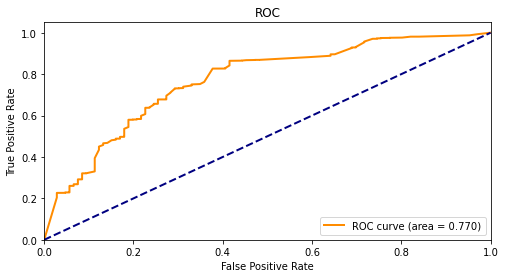

In [14]:
lib.auc_curve(y, hasil_prediksi);

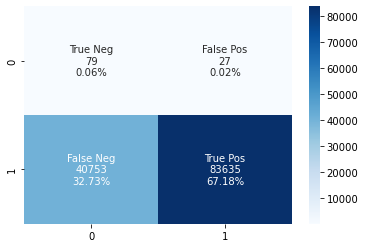

In [15]:
#aktual, predicted
lib.confusion_matrix_plot(y, hasil_prediksi_2['prediksi'])

In [16]:
tn, fp, fn, tp

(79, 27, 40753, 83635)

In [21]:
tp / (tp+fp), tp / (tp+fn), (tp+tn) / 124494

(0.9996772728359351, 0.6723719329838891, 0.672434012884155)

In [17]:
precision_score(hasil_prediksi_2['aktual'], hasil_prediksi_2['prediksi']), recall_score(hasil_prediksi_2['aktual'], hasil_prediksi_2['prediksi'])

(0.9996772728359351, 0.6723719329838891)

-- End of Script